# Continuous Glucose Monitoring

This notebook serves as an introduction to working with the CGM data in mHealth format. It will open one file and make a few plots.

Information on this format may be found at https://github.com/openmhealth 


File organization is expected to follow this pattern:

pilot_data_root           
&emsp;wearable_blood_glucose    
&emsp;&emsp;manifest.tsv    
&emsp;&emsp;continuous_glucose_monitoring    
&emsp;&emsp;&emsp;dexcom_g6    
&emsp;&emsp;&emsp;&emsp;0001    
&emsp;&emsp;&emsp;&emsp;&emsp;0001_DEX.json     
&emsp;&emsp;&emsp;&emsp;0002    
&emsp;&emsp;&emsp;&emsp;&emsp;0002_DEX.json   
&emsp;&emsp;&emsp;&emsp;... etc.

In [1]:
import json

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt  # to make plots
import matplotlib.dates as mdates  # to use ConciseDateFormatter

In [2]:
print(f'pd version: {pd.__version__}')  # pd 2.1.4 was used for dev

pd version: 2.2.3


## custom path -- change to match your file structure

In [3]:
pilot_data_root = "C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset/"  # change this to your own path

# Read the manifest

In [4]:
manifest_path = pilot_data_root + "/wearable_blood_glucose/manifest.tsv"
print(manifest_path)

C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset//wearable_blood_glucose/manifest.tsv


In [5]:
dfm = pd.read_csv(manifest_path, sep='\t')
print(dfm.columns)

Index(['participant_id', 'glucose_filepath', 'glucose_level_record_count',
       'average_glucose_level_mg_dl', 'glucose_sensor_sampling_duration_days',
       'glucose_sensor_id', 'manufacturer', 'manufacturer_model_name'],
      dtype='object')


In [6]:
dfm['participant_id'].nunique()  # number of unique participants

1049

In [7]:
dfm.head()

,participant_id,glucose_filepath,glucose_level_record_count,average_glucose_level_mg_dl,glucose_sensor_sampling_duration_days,glucose_sensor_id,manufacturer,manufacturer_model_name
0,1001,wearable_blood_glucose/continuous_glucose_moni...,2856,123.304272,11,PG15103578,Dexcom,G6
1,1002,wearable_blood_glucose/continuous_glucose_moni...,2844,116.446203,11,PG15103578,Dexcom,G6
2,1003,wearable_blood_glucose/continuous_glucose_moni...,2856,208.075280,11,PG15103578,Dexcom,G6
3,1004,wearable_blood_glucose/continuous_glucose_moni...,2856,188.661064,11,PG15103578,Dexcom,G6
4,1005,wearable_blood_glucose/continuous_glucose_moni...,2856,262.778361,11,PG15103578,Dexcom,G6


In [8]:
display(dfm.nunique())

display(dfm['glucose_sensor_sampling_duration_days'].unique())

participant_id                           1049
glucose_filepath                         1049
glucose_level_record_count                247
average_glucose_level_mg_dl              1049
glucose_sensor_sampling_duration_days      12
glucose_sensor_id                           8
manufacturer                                1
manufacturer_model_name                     1
dtype: int64

array([11,  9, 10,  8,  5,  2, 12, 13,  6,  7,  3,  4])

In [9]:
key_columns = ['participant_id', 'average_glucose_level_mg_dl',
               'glucose_sensor_sampling_duration_days']  # optionally view only a few columns

dfm[key_columns].head(2)

,participant_id,average_glucose_level_mg_dl,glucose_sensor_sampling_duration_days
0,1001,123.304272,11
1,1002,116.446203,11


# Select a set of data to explore

In [10]:
pid = 1039  # select a participant ID

pid_cgm = dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0]
print(f'{pid} full path: {pid_cgm}')

1039 full path: wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1039/1039_DEX.json


In [11]:
cgm_path = pilot_data_root + pid_cgm
print(cgm_path)

C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1039/1039_DEX.json


## read and explore the data

### open the mHealth formatted data

In [12]:
# read the mHealth formatted data as json
with open(cgm_path,'r') as f:
    data = json.load(f)
print(data.keys())

dict_keys(['header', 'body'])


In [13]:
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

In [14]:
cgm_header = flatten_json(data['header'])
print(cgm_header)

{'uuid': 'AIREADI-1039', 'creation_date_time': '2024-10-01T21:23:57Z', 'patient_id': 'AIREADI-1039', 'schema_id_namespace': 'omh', 'schema_id_name': 'blood-glucose', 'schema_id_version': 3.0, 'modality': 'sensed', 'acquistion_rate_number_of_times': 1, 'acquistion_rate_time_window_value': 5, 'acquistion_rate_time_window_unit': 'min', 'external_datasheets_datasheet_type': 'source_device', 'external_datasheets_datasheet_reference': 'iri-of-cgm-device', 'timezone': 'pst'}


In [15]:
# CGM observations are in a list of nested dicts; flatten these 
list_of_body_dicts = list()
for observation in data['body']['cgm']:
    flat_obs = flatten_json(observation)
    list_of_body_dicts.append(flat_obs)

### convert to pandas data frame

In [16]:
df = pd.DataFrame.from_records(list_of_body_dicts)
print(df.shape)

(2628, 9)


In [17]:
print(f'CGM columns: {df.columns}')

CGM columns: Index(['effective_time_frame_time_interval_start_date_time',
       'effective_time_frame_time_interval_end_date_time', 'event_type',
       'source_device_id', 'blood_glucose_unit', 'blood_glucose_value',
       'transmitter_time_unit', 'transmitter_time_value', 'transmitter_id'],
      dtype='object')


In [18]:
df.rename(columns={'effective_time_frame_time_interval_start_date_time':'start_time',
                   'effective_time_frame_time_interval_end_date_time': 'end_time'}, inplace=True)

In [19]:
def convert_time_string_to_datetime(t_str):
    '''Converts time string to datetime format. Does not convert to local time.
    Args:
        t_str (str): UTC time string such as 2023-08-01T20:39:33Z 
    Returns: datetime object
    '''
    datetime_object = datetime.strptime(t_str, '%Y-%m-%dT%H:%M:%SZ')  # 4 digit Year
    return datetime_object

In [20]:
df['start_dtime'] = df.apply(lambda row: convert_time_string_to_datetime(row['start_time']), axis=1)

In [21]:
df.info()  # note that blood_glucose_value may be object; int is expected

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   start_time              2628 non-null   object        
 1   end_time                2628 non-null   object        
 2   event_type              2628 non-null   object        
 3   source_device_id        2628 non-null   object        
 4   blood_glucose_unit      2628 non-null   object        
 5   blood_glucose_value     2628 non-null   object        
 6   transmitter_time_unit   2628 non-null   object        
 7   transmitter_time_value  2628 non-null   int64         
 8   transmitter_id          2628 non-null   object        
 9   start_dtime             2628 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 205.4+ KB


In [22]:
df.head()

,start_time,end_time,event_type,source_device_id,blood_glucose_unit,blood_glucose_value,transmitter_time_unit,transmitter_time_value,transmitter_id,start_dtime
0,2023-10-09T18:05:59Z,2023-10-09T18:05:59Z,EGV,PG15103578,mg/dL,87,long integer,7573,35BNHL,2023-10-09 18:05:59
1,2023-10-09T18:10:59Z,2023-10-09T18:10:59Z,EGV,PG15103578,mg/dL,88,long integer,7873,35BNHL,2023-10-09 18:10:59
2,2023-10-09T18:15:59Z,2023-10-09T18:15:59Z,EGV,PG15103578,mg/dL,90,long integer,8173,35BNHL,2023-10-09 18:15:59
3,2023-10-09T18:20:59Z,2023-10-09T18:20:59Z,EGV,PG15103578,mg/dL,90,long integer,8473,35BNHL,2023-10-09 18:20:59
4,2023-10-09T18:25:59Z,2023-10-09T18:25:59Z,EGV,PG15103578,mg/dL,95,long integer,8773,35BNHL,2023-10-09 18:25:59


In [23]:
# show rows with low and high blood glucose values
df[df['blood_glucose_value'].isin(['Low', 'High'])]

,start_time,end_time,event_type,source_device_id,blood_glucose_unit,blood_glucose_value,transmitter_time_unit,transmitter_time_value,transmitter_id,start_dtime
15,2023-10-09T19:20:59Z,2023-10-09T19:20:59Z,EGV,PG15103578,mg/dL,Low,long integer,12073,35BNHL,2023-10-09 19:20:59
18,2023-10-09T19:35:59Z,2023-10-09T19:35:59Z,EGV,PG15103578,mg/dL,Low,long integer,12973,35BNHL,2023-10-09 19:35:59


In [24]:
mask_bg_int_only = ~df['blood_glucose_value'].isin(['Low','High'])
bg_min = df[mask_bg_int_only]["blood_glucose_value"].min()
bg_max = df[mask_bg_int_only]["blood_glucose_value"].max()
print(f'Lowest blood_glucose_value: {bg_min}')
print(f'Highest blood_glucose_value: {bg_max}')

Lowest blood_glucose_value: 41
Highest blood_glucose_value: 207


## plot blood glucose values

### handle non-numeric blood glucose values

Most values are integers, but some may be either "High" or "Low".     
The sensor reports    
 - <  40 "Low"     
 - \> 400 "High"
   
The terms "Low" and "High" can be replaced with these values, or more extreme values could be used (0, 500) for visualization purposes.

In [25]:
# df['blood_glucose_value'].value_counts()  # peek at the value distribution
low_value = 40  # select a value to use for low
high_value = 400  # select a value to use for high

if (0):
    df.replace({"Low": low_value, "High": high_value}, inplace=True)  # notebook dev used pd 2.1.4
else:  # to avoid the FutureWarning regarding Downcasting behavior in 'replace'

    def replace_alt(val, low_value, high_value):
        if val == "Low":
            return low_value
        elif val == "High":
            return high_value
        else:
            return val

    df['blood_glucose_value'] = df.apply(lambda x: replace_alt(x['blood_glucose_value'],
                                                               low_value, high_value), axis=1)

In [26]:
df.info()  # optional view of the Dtype for each column of data; blood glucose should be int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   start_time              2628 non-null   object        
 1   end_time                2628 non-null   object        
 2   event_type              2628 non-null   object        
 3   source_device_id        2628 non-null   object        
 4   blood_glucose_unit      2628 non-null   object        
 5   blood_glucose_value     2628 non-null   int64         
 6   transmitter_time_unit   2628 non-null   object        
 7   transmitter_time_value  2628 non-null   int64         
 8   transmitter_id          2628 non-null   object        
 9   start_dtime             2628 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 205.4+ KB


In [27]:
yaxis_adjusts_to_data = True

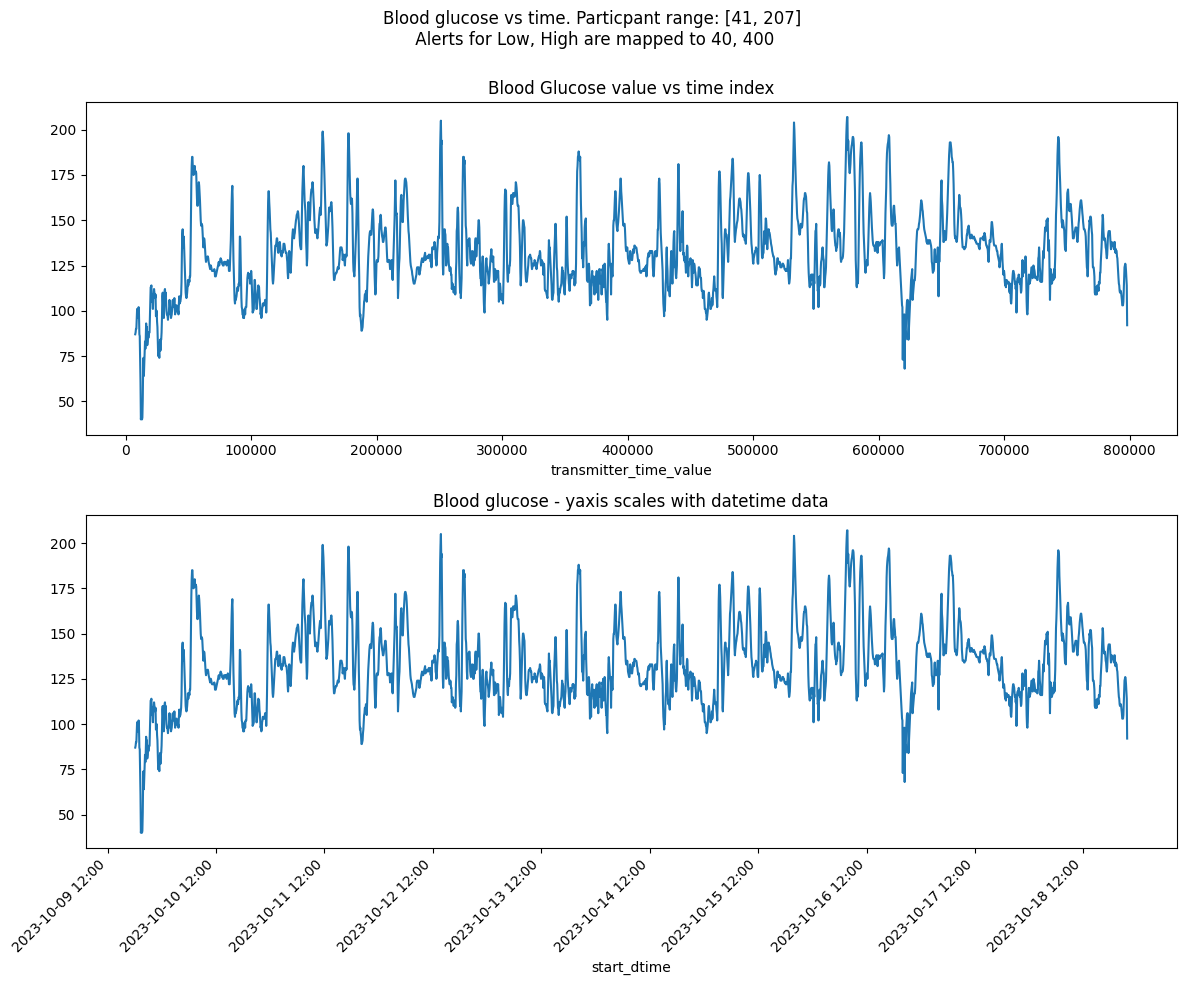

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle(f'Blood glucose vs time. Particpant range: [{bg_min}, {bg_max}]\n Alerts for Low, High are mapped to {low_value}, {high_value}\n')

df.plot.line(x='transmitter_time_value', y='blood_glucose_value', ax=ax[0], legend=False)
ax[0].set_title("Blood Glucose value vs time index")

df.plot.line(x='start_dtime', y='blood_glucose_value', ax=ax[1], legend=False)
ax[1].set_title("Blood Glucose value vs. timestamp")
if (yaxis_adjusts_to_data):
    ax[1].set_title('Blood glucose - yaxis scales with datetime data')
else:
    ax[1].set_title('Blood glucose - yaxis [0, 505]')
    ax[1].set_ylim(0, 505)
ax[1].xaxis.set_major_locator(mdates.HourLocator(byhour=12))  # each day at noon
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=True,       # set ticks along the bottom edge on
#     top=False,         # set ticks along the top edge off
#     labelbottom=True)  # set labels along the bottom edge on

# plt.xlabel('timestamp')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [29]:
print('Done')

Done


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\sit

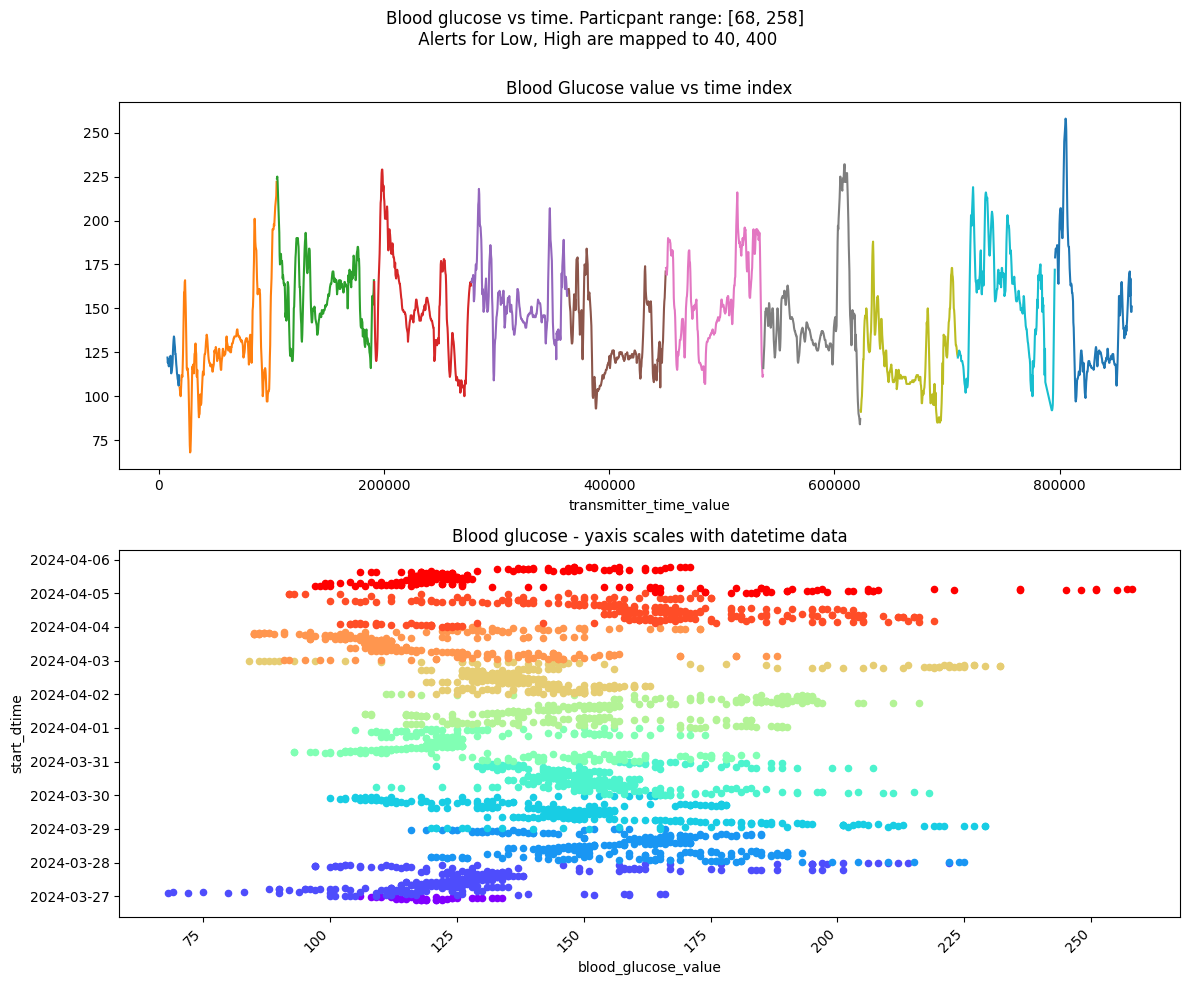

Done


In [30]:
# Entire code into a single function for reuse
def read_cgm_data(pid, pilot_data_root, low_value=40, high_value=400, yaxis_adjusts_to_data=True):
    '''Reads the CGM data for a participant, and plots the blood glucose values vs. time.
    Args:
        pid (int): participant ID
        pilot_data_root (str): root path for the data files
        low_value (int): value to use for 'Low' blood glucose
        high_value (int): value to use for 'High' blood glucose
        yaxis_adjusts_to_data (bool): True to let y-axis adjust to data range
    Returns: None
    '''
    manifest_path = pilot_data_root + "/wearable_blood_glucose/manifest.tsv"
    dfm = pd.read_csv(manifest_path, sep='\t')
    pid_cgm = dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0]
    cgm_path = pilot_data_root + pid_cgm
    with open(cgm_path,'r') as f:
        data = json.load(f)
    list_of_body_dicts = list()
    for observation in data['body']['cgm']:
        flat_obs = flatten_json(observation)
        list_of_body_dicts.append(flat_obs)
    df = pd.DataFrame.from_records(list_of_body_dicts)
    df.rename(columns={'effective_time_frame_time_interval_start_date_time':'start_time',
                       'effective_time_frame_time_interval_end_date_time': 'end_time'}, inplace=True)
    df['start_dtime'] = df.apply(lambda row: convert_time_string_to_datetime(row['start_time']), axis=1)
    mask_bg_int_only = ~df['blood_glucose_value'].isin(['Low','High'])
    bg_min = df[mask_bg_int_only]["blood_glucose_value"].min()
    bg_max = df[mask_bg_int_only]["blood_glucose_value"].max()
    if (0):
        df.replace({"Low": low_value, "High": high_value}, inplace=True)
    else:
        df['blood_glucose_value'] = df.apply(lambda x: replace_alt(x['blood_glucose_value'],
                                                                   low_value, high_value), axis=1)
    # Create a new column for the date
    df['date'] = df['start_dtime'].dt.date

    yaxis_adjusts_to_data = True
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(f'Blood glucose vs time. Particpant range: [{bg_min}, {bg_max}]\n Alerts for Low, High are mapped to {low_value}, {high_value}\n')
    
    for date, group in df.groupby('date'):
        group.plot.line(x='transmitter_time_value', y='blood_glucose_value', ax=ax[0], label=date, legend=False)
    ax[0].set_title("Blood Glucose value vs time index")

    # Assign a unique color to each date
    colors = plt.cm.rainbow(np.linspace(0, 1, df['date'].nunique()))
    color_map = dict(zip(df['date'].unique(), colors))

    for date, group in df.groupby('date'):
        group.plot.scatter(x='blood_glucose_value', y='start_dtime', ax=ax[1], label=date, color=color_map[date], legend=False)
    ax[1].set_title("Blood Glucose value vs. timestamp")

    if (yaxis_adjusts_to_data):
        ax[1].set_title('Blood glucose - yaxis scales with datetime data')
    else:
        ax[1].set_title('Blood glucose - yaxis [0, 505]')
        ax[1].set_ylim(0, 505)
    # ax[1].xaxis.set_major_locator(mdates.HourLocator(byhour=12))  # each day at noon    
    # ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    return

# Test the function
pid = 1202
read_cgm_data(pid, pilot_data_root, low_value=40, high_value=400, yaxis_adjusts_to_data=True)

print('Done')


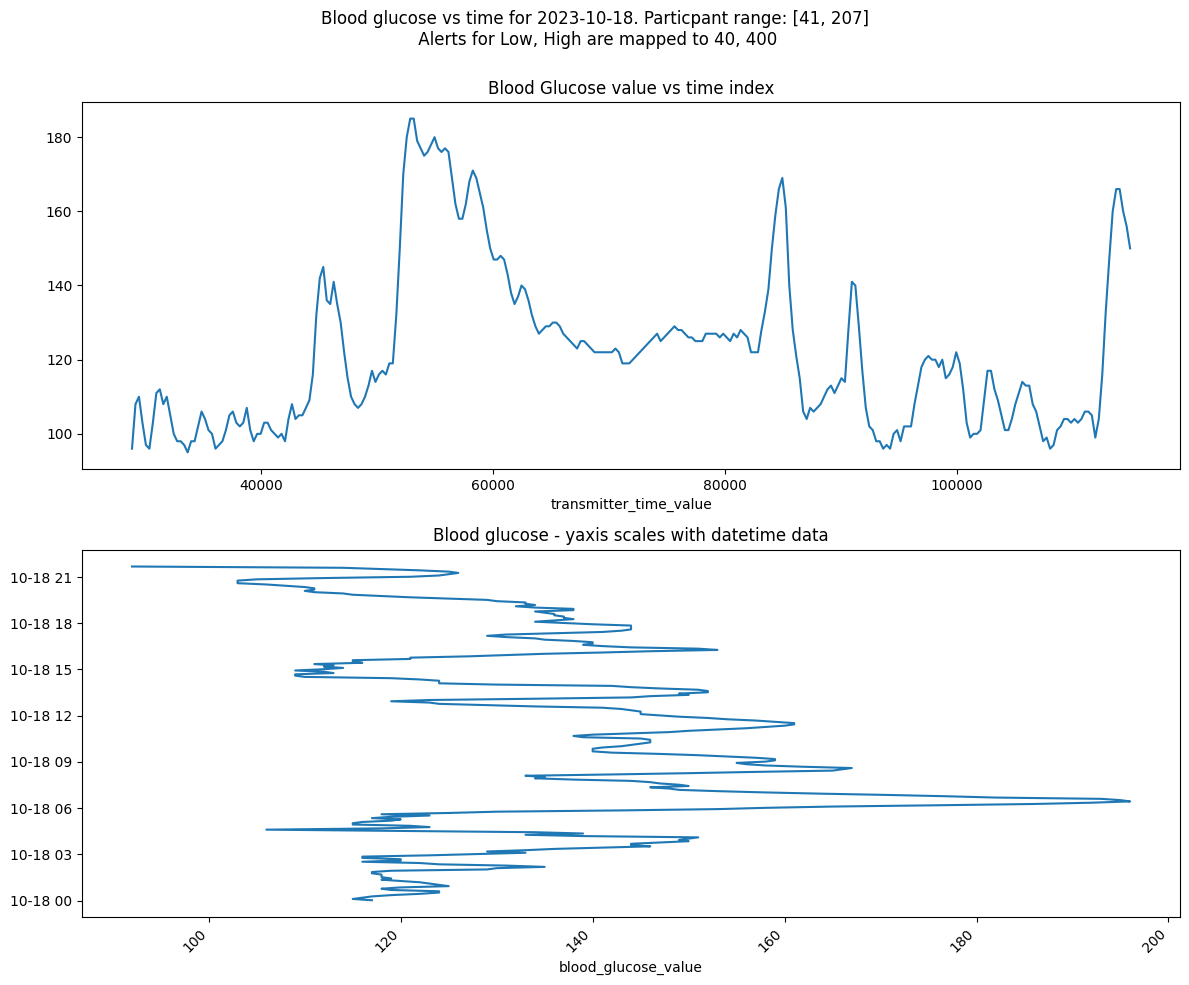

In [32]:
# Filter the dataframe for the first date
df['date'] = df['start_dtime'].dt.date

first_date = df['date'][300]
df_first_date = df[df['date'] == first_date]

first_date = df['date'].max()
df_last_date = df[df['date'] == first_date]

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle(f'Blood glucose vs time for {first_date}. Particpant range: [{bg_min}, {bg_max}]\n Alerts for Low, High are mapped to {low_value}, {high_value}\n')

df_first_date.plot.line(x='transmitter_time_value', y='blood_glucose_value', ax=ax[0], legend=False)
ax[0].set_title("Blood Glucose value vs time index")

df_last_date.plot.line(x='blood_glucose_value', y='start_dtime', ax=ax[1], legend=False)
ax[1].set_title("Blood Glucose value vs. timestamp")

if (yaxis_adjusts_to_data):
    ax[1].set_title('Blood glucose - yaxis scales with datetime data')
else:
    ax[1].set_title('Blood glucose - yaxis [0, 505]')
    ax[1].set_ylim(0, 505)
# ax[1].xaxis.set_major_locator(mdates.HourLocator(byhour=12))  # each day at noon
# ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [33]:
healthy = [1002, 1006, 1021, 1030, 1032, 1033, 1037, 1039, 1042, 1043, 1048, 1050, 1051, 1053, 1054, 1055, 1057, 1060, 1061, 1062, 1064, 1065, 1069, 1074, 1079, 1084, 1086, 1087, 1089, 1098, 1099, 1100, 1106, 1109, 1111, 1114, 1116, 1117, 1118, 1120, 1121, 1122, 1124, 1128, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1140, 1141, 1145, 1152, 1153, 1159, 1160, 1162, 1164, 1166, 1169, 1175, 1176, 1178, 1180, 1181, 1182, 1183, 1186, 1189, 1194, 1195, 1198, 1199, 1205, 1208, 1211, 1217, 1218, 1219, 1220, 1224, 1225, 1226, 1227, 1229, 1233, 1235, 1236, 1237, 1241, 1242, 1247, 1250, 1251, 1254, 1256, 1257, 1258, 1260, 1261, 1265, 1266, 1268, 1269, 1270, 1271, 1272, 1275, 1278, 1280, 1281, 1284, 1285, 1288, 1289, 1291, 1293, 1294, 1295, 1297, 1299, 1303, 1305, 1307, 1308, 1309, 1312, 1313, 1314, 1315, 1321, 1325, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1339, 1340, 1342, 1345, 1346, 1349, 1350, 1353, 1360, 1363, 1364, 1365, 1368, 1377, 1384, 1385, 4001, 4002, 4005, 4018, 4020, 4024, 4025, 4026, 4028, 4033, 4039, 4040, 4041, 4043, 4050, 4051, 4052, 4055, 4056, 4060, 4061, 4063, 4068, 4069, 4074, 4078, 4082, 4084, 4088, 4089, 4090, 4092, 4093, 4098, 4106, 4113, 4114, 4115, 4116, 4123, 4125, 4137, 4141, 4143, 4146, 4148, 4149, 4153, 4155, 4156, 4157, 4165, 4166, 4170, 4171, 4175, 4179, 4180, 4182, 4184, 4189, 4191, 4192, 4196, 4199, 4200, 4205, 4208, 4212, 4213, 4217, 4227, 4233, 4238, 4240, 4244, 4245, 4255, 4267, 4273, 4282, 4293, 4297, 4298, 7008, 7010, 7014, 7017, 7018, 7023, 7024, 7025, 7026, 7027, 7029, 7032, 7033, 7037, 7038, 7039, 7041, 7045, 7048, 7051, 7056, 7064, 7066, 7068, 7072, 7073, 7082, 7084, 7087, 7089, 7092, 7105, 7106, 7108, 7110, 7113, 7114, 7115, 7117, 7118, 7121, 7122, 7124, 7125, 7126, 7128, 7132, 7136, 7137, 7138, 7139, 7142, 7144, 7145, 7148, 7149, 7152, 7156, 7157, 7158, 7159, 7160, 7161, 7164, 7166, 7172, 7173, 7175, 7177, 7178, 7179, 7183, 7190, 7196, 7198, 7202, 7209, 7213, 7216, 7217, 7220, 7225, 7232, 7233, 7234, 7239, 7241, 7242, 7243, 7254, 7256, 7259, 7260, 7261, 7262, 7263, 7269, 7275, 7281, 7285, 7292, 7293, 7295, 7297, 7308, 7315, 7317, 7327, 7332, 7334, 7336, 7338, 7339, 7340, 7344, 7346, 7357, 7360, 7363, 7377, 7381, 7383, 7402, 7408]

pre_diabetic = [1001, 1008, 1011, 1022, 1024, 1026, 1029, 1034, 1038, 1040, 1044, 1045, 1046, 1047, 1049, 1059, 1066, 1067, 1068, 1072, 1075, 1077, 1083, 1091, 1093, 1097, 1101, 1103, 1104, 1107, 1112, 1119, 1126, 1129, 1143, 1146, 1149, 1150, 1154, 1158, 1161, 1163, 1167, 1168, 1172, 1177, 1184, 1185, 1188, 1192, 1193, 1196, 1200, 1204, 1209, 1210, 1214, 1223, 1228, 1234, 1238, 1244, 1246, 1255, 1262, 1267, 1273, 1274, 1277, 1279, 1282, 1290, 1298, 1302, 1316, 1317, 1319, 1320, 1323, 1324, 1328, 1337, 1338, 1341, 1348, 1351, 1352, 1354, 1366, 1369, 1374, 1379, 1380, 1381, 1383, 4006, 4008, 4012, 4017, 4030, 4034, 4035, 4037, 4042, 4045, 4062, 4065, 4072, 4073, 4077, 4085, 4091, 4096, 4097, 4104, 4117, 4120, 4121, 4126, 4127, 4135, 4138, 4139, 4150, 4152, 4154, 4158, 4161, 4164, 4168, 4169, 4174, 4176, 4183, 4190, 4193, 4195, 4202, 4203, 4206, 4211, 4215, 4216, 4220, 4222, 4224, 4225, 4226, 4235, 4242, 4247, 4249, 4253, 4256, 4258, 4261, 4264, 4265, 4269, 4270, 4277, 4285, 4287, 4296, 4301, 4302, 7005, 7007, 7019, 7022, 7043, 7047, 7052, 7058, 7069, 7070, 7074, 7077, 7079, 7100, 7107, 7119, 7129, 7141, 7147, 7154, 7155, 7162, 7165, 7170, 7192, 7194, 7207, 7218, 7221, 7226, 7228, 7229, 7236, 7244, 7249, 7250, 7252, 7255, 7257, 7258, 7273, 7274, 7279, 7290, 7299, 7307, 7309, 7319, 7326, 7337, 7341, 7347, 7352, 7353, 7355, 7359, 7361, 7362, 7365, 7366, 7369, 7375, 7378, 7379, 7386, 7389, 7390, 7391, 7396, 7398, 7401]

oral = [1003, 1004, 1009, 1010, 1012, 1014, 1015, 1016, 1017, 1019, 1020, 1025, 1027, 1028, 1031, 1041, 1052, 1058, 1070, 1071, 1076, 1078, 1080, 1082, 1092, 1094, 1096, 1105, 1108, 1110, 1113, 1115, 1125, 1127, 1130, 1138, 1139, 1142, 1148, 1151, 1155, 1171, 1173, 1174, 1179, 1190, 1191, 1203, 1206, 1207, 1215, 1216, 1221, 1222, 1230, 1232, 1240, 1243, 1245, 1248, 1253, 1263, 1264, 1283, 1287, 1292, 1300, 1301, 1304, 1306, 1310, 1311, 1322, 1326, 1327, 1343, 1344, 1347, 1355, 1356, 1357, 1359, 1361, 1362, 1367, 1370, 1371, 1372, 1373, 1375, 1376, 1378, 4009, 4011, 4014, 4016, 4019, 4029, 4036, 4038, 4044, 4046, 4048, 4049, 4057, 4058, 4064, 4067, 4070, 4071, 4075, 4076, 4081, 4086, 4087, 4094, 4095, 4099, 4102, 4107, 4108, 4110, 4112, 4118, 4119, 4122, 4124, 4128, 4129, 4130, 4131, 4133, 4134, 4136, 4140, 4145, 4147, 4151, 4159, 4160, 4162, 4167, 4178, 4185, 4186, 4187, 4188, 4194, 4201, 4207, 4214, 4221, 4223, 4228, 4229, 4230, 4231, 4234, 4236, 4237, 4239, 4241, 4243, 4246, 4248, 4251, 4252, 4254, 4257, 4259, 4260, 4262, 4263, 4266, 4268, 4272, 4279, 4280, 4281, 4283, 4284, 4286, 4288, 4289, 4290, 4291, 4292, 4294, 4295, 4299, 4300, 7001, 7003, 7004, 7011, 7012, 7013, 7016, 7021, 7049, 7060, 7061, 7062, 7065, 7067, 7071, 7076, 7078, 7080, 7081, 7086, 7096, 7097, 7098, 7099, 7102, 7103, 7109, 7111, 7112, 7120, 7127, 7130, 7133, 7134, 7135, 7140, 7143, 7146, 7150, 7163, 7167, 7168, 7169, 7171, 7174, 7180, 7181, 7182, 7185, 7188, 7189, 7191, 7197, 7199, 7201, 7204, 7206, 7210, 7214, 7219, 7223, 7224, 7227, 7230, 7231, 7240, 7245, 7247, 7248, 7251, 7264, 7265, 7266, 7267, 7270, 7271, 7272, 7277, 7278, 7282, 7286, 7287, 7288, 7289, 7294, 7298, 7302, 7304, 7306, 7310, 7311, 7312, 7313, 7314, 7318, 7325, 7328, 7331, 7335, 7342, 7343, 7349, 7350, 7351, 7354, 7356, 7358, 7364, 7367, 7368, 7371, 7372, 7374, 7380, 7382, 7385, 7387, 7392, 7393, 7394, 7395, 7397, 7399, 7404, 7405, 7406, 7407, 7410, 7411]

insulin = [1005, 1007, 1013, 1018, 1023, 1035, 1036, 1056, 1063, 1073, 1081, 1085, 1088, 1090, 1095, 1123, 1144, 1156, 1157, 1170, 1201, 1202, 1212, 1213, 1231, 1239, 1249, 1252, 1259, 1276, 1286, 1318, 1329, 4004, 4022, 4054, 4059, 4066, 4079, 4080, 4083, 4101, 4103, 4105, 4109, 4111, 4132, 4142, 4163, 4172, 4173, 4177, 4181, 4197, 4198, 4209, 4210, 4218, 4219, 4232, 4250, 4271, 4274, 4275, 4278, 7006, 7009, 7034, 7040, 7044, 7053, 7059, 7063, 7090, 7093, 7104, 7116, 7123, 7131, 7153, 7176, 7184, 7186, 7187, 7193, 7195, 7200, 7203, 7208, 7211, 7212, 7215, 7222, 7235, 7237, 7238, 7246, 7253, 7268, 7276, 7280, 7283, 7284, 7291, 7296, 7300, 7301, 7303, 7305, 7316, 7320, 7321, 7322, 7323, 7324, 7329, 7330, 7333, 7345, 7348, 7370, 7373, 7376, 7384, 7388, 7403, 7409]

# fron the manifest.tsv fetch the average_glucose_level_mg_dl of patients whos id is in healthy list
display(dfm[dfm['participant_id'].isin(healthy)]['average_glucose_level_mg_dl'].describe())
display(dfm[dfm['participant_id'].isin(pre_diabetic)]['average_glucose_level_mg_dl'].describe())
display(dfm[dfm['participant_id'].isin(oral)]['average_glucose_level_mg_dl'].describe())
display(dfm[dfm['participant_id'].isin(insulin)]['average_glucose_level_mg_dl'].describe())


# # from the manifest.tsv fetch the average_glucose_level_mg_dl of patients whos id is in healthy list
# dfm[dfm['participant_id'].isin(healthy)]['average_glucose_level_mg_dl'].hist(bins=20)

count    365.000000
mean     120.337772
std       17.142278
min       68.589744
25%      111.451331
50%      118.295926
75%      128.728291
max      278.133758
Name: average_glucose_level_mg_dl, dtype: float64

count    237.000000
mean     128.647238
std       24.107935
min       67.560000
25%      114.568978
50%      124.898449
75%      137.332983
max      290.045364
Name: average_glucose_level_mg_dl, dtype: float64

count    320.000000
mean     150.792876
std       36.068790
min       91.385225
25%      125.267513
50%      141.775735
75%      168.192445
max      308.993336
Name: average_glucose_level_mg_dl, dtype: float64

count    127.000000
mean     177.497007
std       45.458261
min      108.544180
25%      144.804447
50%      167.943322
75%      199.158916
max      300.522583
Name: average_glucose_level_mg_dl, dtype: float64

## Blood Glucose vs time for all 4 groups of category


C:\Users\nikhi\AppData\Local\Temp\ipykernel_57056\2596409272.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pid['blood_glucose_value'] = df_pid['blood_glucose_value'].replace({"Low": low_value, "High": high_value})
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\pa

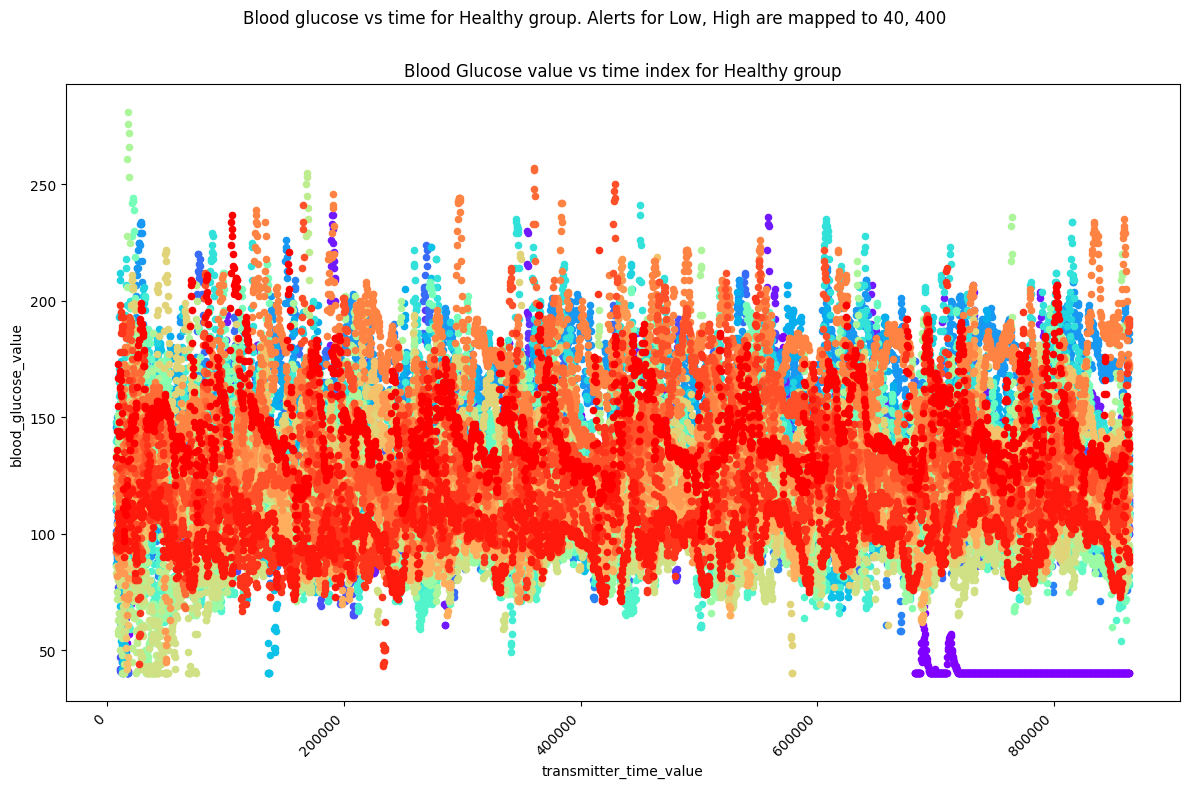

C:\Users\nikhi\AppData\Local\Temp\ipykernel_57056\2596409272.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pid['blood_glucose_value'] = df_pid['blood_glucose_value'].replace({"Low": low_value, "High": high_value})
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\pa

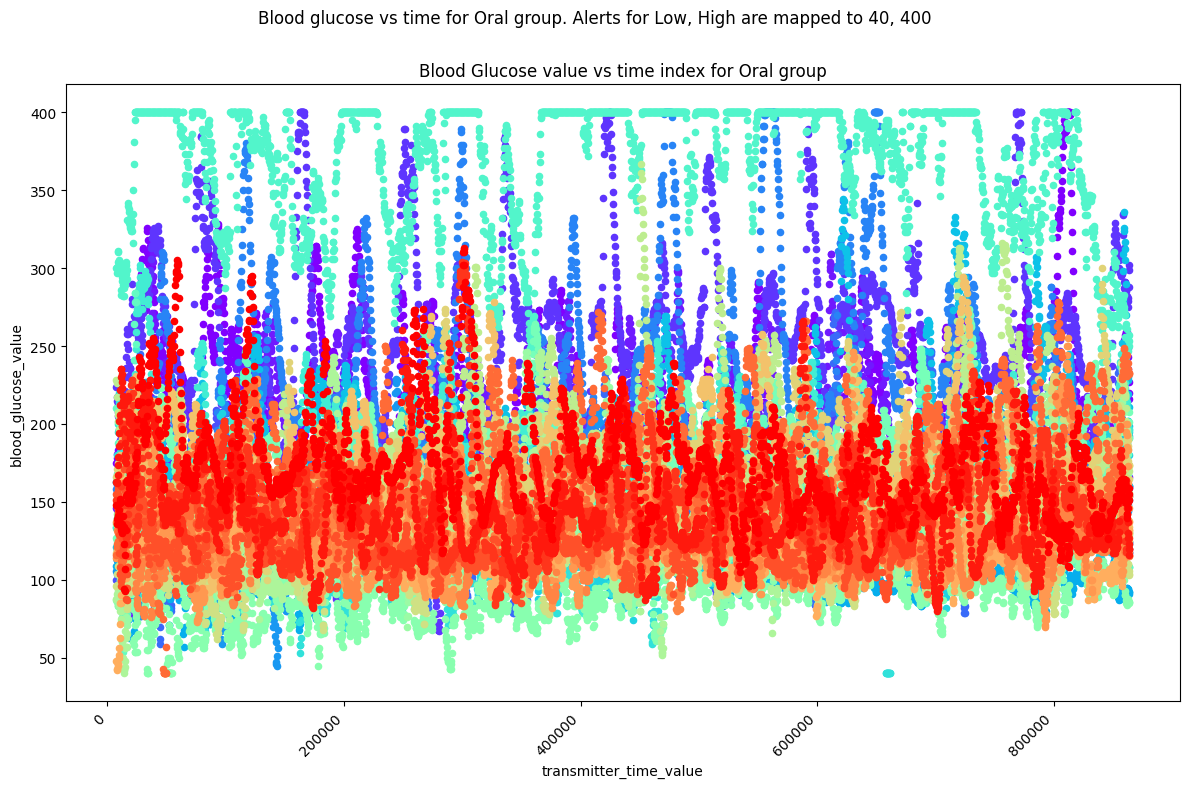

c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\sit

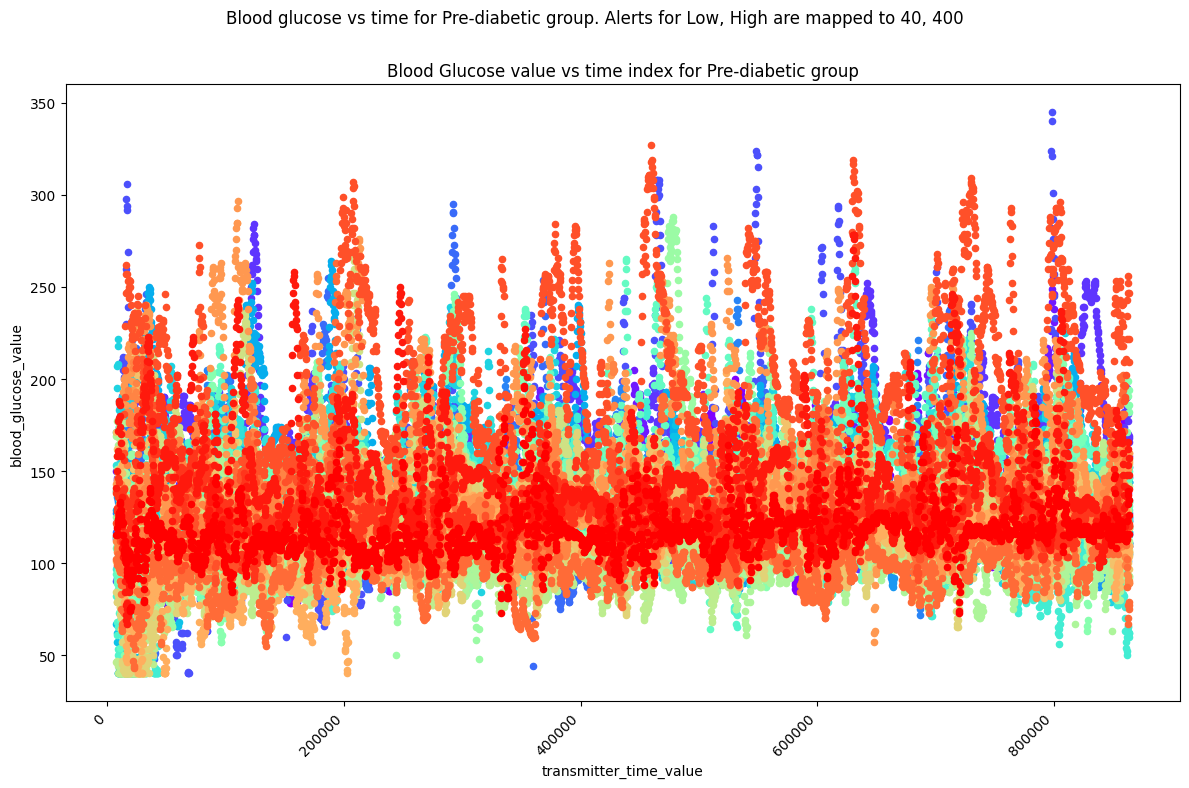

C:\Users\nikhi\AppData\Local\Temp\ipykernel_57056\2596409272.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pid['blood_glucose_value'] = df_pid['blood_glucose_value'].replace({"Low": low_value, "High": high_value})
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
C:\Users\nikhi\AppData\Local\Temp\ipykernel_57056\2596409272.py:38: FutureW

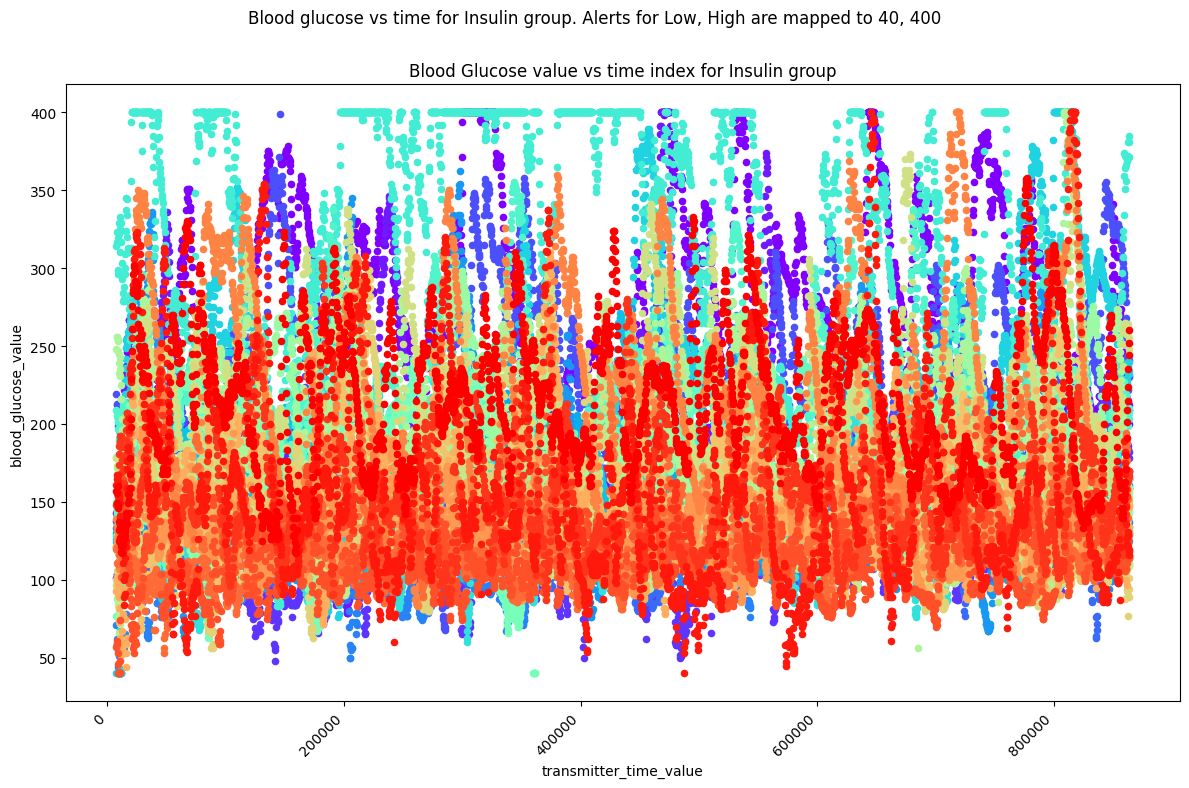

In [35]:
def plot_blood_glucose_for_groups(groups, group_names, pilot_data_root, low_value=40, high_value=400):
    '''Plots blood glucose values for multiple groups of participants.
    Args:
        groups (list of lists): List containing participant ID lists for each group
        group_names (list of str): List containing names of the groups
        pilot_data_root (str): Root path for the data files
        low_value (int): Value to use for 'Low' blood glucose
        high_value (int): Value to use for 'High' blood glucose
    Returns: None
    '''
    for group, group_name in zip(groups, group_names):
        # Define a color map for the participants
        colors = plt.cm.rainbow(np.linspace(0, 1, len(group)))
        color_map = dict(zip(group, colors))

        fig, ax = plt.subplots(figsize=(12, 8))
        fig.suptitle(f'Blood glucose vs time for {group_name} group. Alerts for Low, High are mapped to {low_value}, {high_value}\n')

        for pid in group:
            # Get the glucose file path for the participant
            pid_cgm = dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0]
            cgm_path = pilot_data_root + pid_cgm

            # Read the CGM data
            with open(cgm_path, 'r') as f:
                data = json.load(f)

            # Flatten the CGM observations
            list_of_body_dicts = [flatten_json(obs) for obs in data['body']['cgm']]

            # Convert to pandas DataFrame
            df_pid = pd.DataFrame.from_records(list_of_body_dicts)
            df_pid.rename(columns={'effective_time_frame_time_interval_start_date_time': 'start_time',
                                   'effective_time_frame_time_interval_end_date_time': 'end_time'}, inplace=True)
            df_pid['start_dtime'] = df_pid.apply(lambda row: convert_time_string_to_datetime(row['start_time']), axis=1)

            # Replace "Low" and "High" values
            df_pid['blood_glucose_value'] = df_pid['blood_glucose_value'].replace({"Low": low_value, "High": high_value})

            # Plot the data
            df_pid.plot.scatter(x='transmitter_time_value', y='blood_glucose_value', ax=ax, color=color_map[pid], legend=True)

        ax.set_title(f"Blood Glucose value vs time index for {group_name} group")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Define the groups and their names
groups = [healthy[:30], oral[:30], pre_diabetic[:30], insulin[:30]]
group_names = ['Healthy', 'Oral', 'Pre-diabetic', 'Insulin']

# Call the function to plot the data
plot_blood_glucose_for_groups(groups, group_names, pilot_data_root, low_value=40, high_value=400)


## cluster


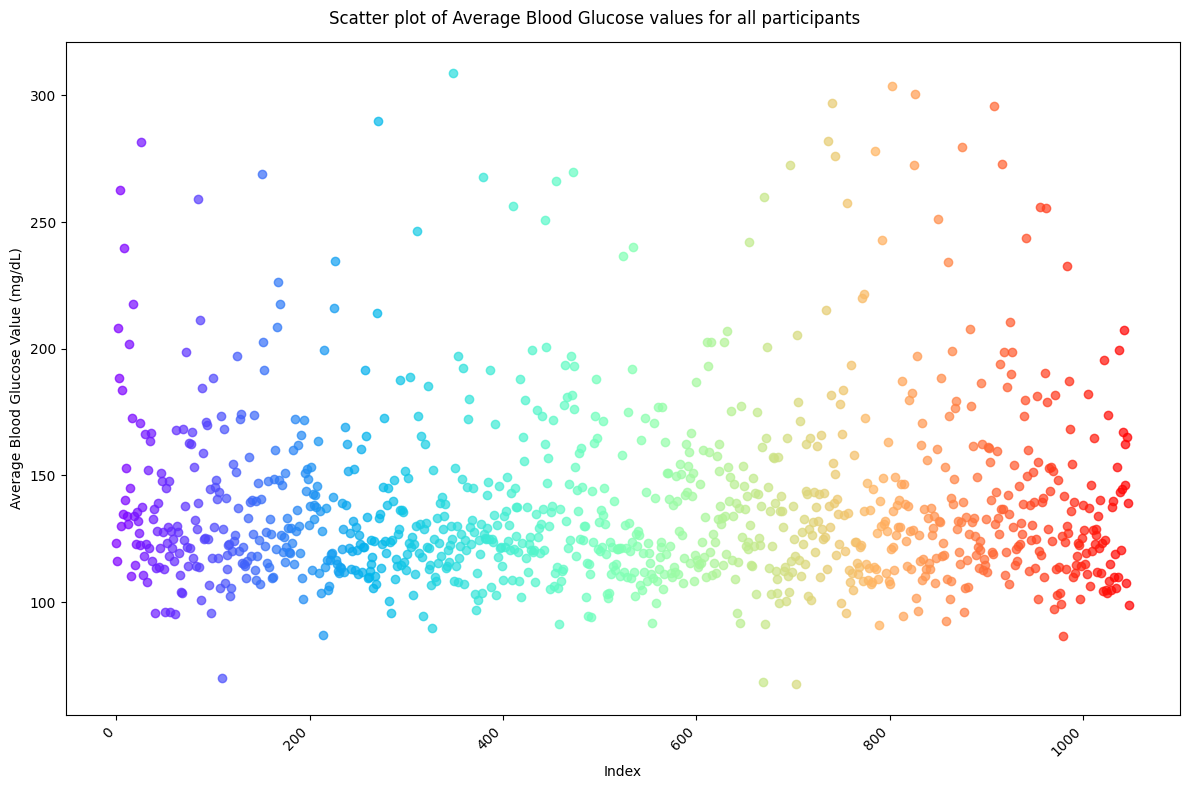

In [46]:
# Read the manifest file
manifest_path = pilot_data_root + "/wearable_blood_glucose/manifest.tsv"
dfm = pd.read_csv(manifest_path, sep='\t')

# Initialize a figure for the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Scatter plot of Average Blood Glucose values for all participants')

# Define a color map for the participants
colors = plt.cm.rainbow(np.linspace(0, 1, len(dfm)))
color_map = dict(zip(dfm.index, colors))

# Scatter plot the average blood glucose values
for idx, row in dfm.iterrows():
    avg_glucose = row['average_glucose_level_mg_dl']
    ax.scatter(idx, avg_glucose, color=color_map[idx], label=idx if idx == 0 else "", alpha=0.7)

plt.xlabel('Index')
plt.ylabel('Average Blood Glucose Value (mg/dL)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
